In [1]:
import os
import re
import pandas as pd
import numpy as np
import nltk
import gensim 
from sklearn.metrics import precision_recall_curve,roc_curve
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding, LSTM,SpatialDropout1D
from keras.layers import Activation
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
os.environ['KERAS_BACKEND']='theano'

In [2]:
data_en = "ISO-8859-1"
df = pd.read_csv('DataSet.csv',encoding=data_en)
df=df[['text']]
# df_temp = pd.DataFrame(df,columns =['username','user_id','timestamp','text'])
df = df.sample(n=25569, random_state=1)
df

,text
3661,Washington reports 818 new cases bringing tota...
12691,??????? ????? ?? ????? ??????? ?? ?????? ?????...
8699,Alarming new data shows #half of #YoungAdults ...
8994,I was the only person wearing a face mask in t...
24261,#COVID19 #coronavirus #europa\nhttps://orf.at/...
...,...
10955,#Ahora #Urgente\nSe confirmaron en este miérco...
17289,California reports 259 new cases and 1 new dea...
5192,Thank you @ReporterCassie and @10News for the ...
12172,What the Dengue Vaccine Riddle Says About the ...


In [3]:
clean1 = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+#"
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")
def preprocess(text,stem=False):
    text = re.sub(clean1,' ',str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df.text = df.text.apply(lambda x: preprocess(x,True))
df.head(20)

,text
3661,washington report 818 new case bring total con...
12691,covid19 stayhom isol selfquarantin
8699,alarm new data show half youngadult (age 18-29...
8994,person wear face mask supermarket today. dont...
24261,#covid19 coronavirus europa
11687,"""the declin influenza case occur exact test co..."
3439,maduro extiend estado de alarma cuarentena en ...
15164,"luo baishan, investigador de la compañía china..."
25076,number peopl victoria hospit battl covid19 alm...
1098,l'influenc des journalist diminu polqc qcpol q...


In [5]:
from textblob import TextBlob
def polarity(text):
    return TextBlob(text).sentiment.polarity
def label1(score):
    if score < 0:
        return 1
    elif score > 0:
        return 2
    else:
        return 0  
df['Polarity'] = df['text'].apply(polarity)
df['c1'] = df['Polarity'].apply(label1)
df.head(50)

,text,Polarity,c1
3661,washington report 818 new case bring total con...,0.081818,2
12691,covid19 stayhom isol selfquarantin,0.000000,0
8699,alarm new data show half youngadult (age 18-29...,0.000606,2
8994,person wear face mask supermarket today. dont...,0.000000,0
24261,#covid19 coronavirus europa,0.000000,0
11687,"""the declin influenza case occur exact test co...",0.250000,2
3439,maduro extiend estado de alarma cuarentena en ...,0.000000,0
15164,"luo baishan, investigador de la compañía china...",0.000000,0
25076,number peopl victoria hospit battl covid19 alm...,-0.250000,1
1098,l'influenc des journalist diminu polqc qcpol q...,0.000000,0


In [6]:
sq_len = 300

def go(df):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df.text)
    vocab_size = len(tokenizer.word_index)+1
    #print(vocab_size)
    x_data = pad_sequences(tokenizer.texts_to_sequences(df['text']),maxlen =sq_len)
    word_index = tokenizer.word_index
    #x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['text']), maxlen=sq_len)
    return x_data, word_index


uniques, ids = np.unique(df.c1, return_inverse=True)
y_data = to_categorical(ids)
x_data , word_index = go(df)
print(y_data)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state=42)




print(x_train.shape)
print(y_train.shape)
input_shape = x_train.shape[1]
#input_shapex = y_train.shape[1]

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

(20455, 300)
(20455, 3)


In [8]:
doc = [_text.split() for _text in df.text]
w2v_size = 3
w2v_window = 7
w2v_epoch = 32
w2v_min_count = 10
w2v_model = gensim.models.word2vec.Word2Vec(size=w2v_size,window = w2v_window ,min_count = w2v_min_count ,workers=8)

In [9]:
w2v_model.build_vocab(doc)

In [10]:
words = w2v_model.wv.vocab.keys()
vocab_size = 60000
#print("Vocab size", vocab_size)
print(len(words))

5088


In [11]:
w2v_model.most_similar("covid19")

C:\Users\admin\Anaconda3\envs\tensorflowsession\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('subscrib', 0.9999830722808838),
 ('"we', 0.9998701810836792),
 ('#dca4covid19', 0.9996271729469299),
 ('art', 0.9991812109947205),
 ('allow', 0.9982412457466125),
 ('covid?19', 0.9980893135070801),
 ('dumptrump2020', 0.9977921843528748),
 ('problems,', 0.9976803660392761),
 ('contr', 0.9976792335510254),
 ('comic', 0.9973883032798767)]

In [12]:
w2v_model.train(doc, total_examples=len(doc), epochs=w2v_epoch)

(9784919, 15365792)

In [13]:
embedding_matrix = np.zeros((vocab_size, w2v_size))
tokenizer = Tokenizer()
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(60000, 3)


In [20]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=3,weights=[embedding_matrix],input_length=input_shape))
#model.add(Embedding(input_dim=vocab_size+1,output_dim=3, input_length = input_shape))
model.add(LSTM(128))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()
learning_rate = 1e-3
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 3)            180000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 247,971
Trainable params: 247,971
Non-trainable params: 0
_________________________________________________________________


In [22]:

saving_path = "./traning_/modelWeights"

BATCH_SIZE = 32
EPOCHS = 20


# load weights

#model.load_weights(saving_path, by_name=False, skip_mismatch=False)

model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

model.save_weights(saving_path, overwrite=True, save_format=None)

Epoch 1/20
640/640 [==============================] - 12s 19ms/step - loss: 5.1692e-04 - accuracy: 0.9998
Epoch 2/20
640/640 [==============================] - 12s 19ms/step - loss: 9.7830e-05 - accuracy: 1.0000
Epoch 3/20
640/640 [==============================] - 12s 19ms/step - loss: 5.8462e-05 - accuracy: 1.0000
Epoch 4/20
640/640 [==============================] - 12s 19ms/step - loss: 2.3696e-05 - accuracy: 1.0000
Epoch 5/20
640/640 [==============================] - 12s 19ms/step - loss: 1.5803e-05 - accuracy: 1.0000
Epoch 6/20
640/640 [==============================] - 12s 19ms/step - loss: 1.1135e-05 - accuracy: 1.0000
Epoch 7/20
640/640 [==============================] - 12s 19ms/step - loss: 7.9267e-06 - accuracy: 1.0000
Epoch 8/20
640/640 [==============================] - 12s 19ms/step - loss: 5.6736e-06 - accuracy: 1.0000
Epoch 9/20
640/640 [==============================] - 12s 19ms/step - loss: 4.0313e-06 - accuracy: 1.0000
Epoch 10/20
640/640 [=========================

In [23]:
result = model.evaluate(x_test, y_test, batch_size = BATCH_SIZE)
prediction = model.predict(x_test)

160/160 [==============================] - 1s 8ms/step - loss: 1.3394 - accuracy: 0.8966


In [24]:
def decoder(predictions):
    return (predictions == predictions.max(axis=1, keepdims=True)).astype(float)
prediction_y = decoder(prediction)
 
acutal_y = uniques[y_test.argmax(1)]
predict_y = uniques[prediction_y.argmax(1)]
print(acutal_y)
print(predict_y)

[0 2 0 ... 2 0 0]
[0 2 1 ... 2 0 0]


In [26]:
import sklearn.metrics  as skmet
cm = skmet.confusion_matrix(acutal_y, predict_y)
print("Confusion Mat: \n", cm)
print("Recall: ", skmet.recall_score(acutal_y, predict_y, average = "weighted"))
print("Precision: ", skmet.precision_score(acutal_y, predict_y, average = "weighted"))
print("F1 Score: ", skmet.f1_score(acutal_y, predict_y, average = "weighted"))
print("Accuracy: ", skmet.accuracy_score(acutal_y, predict_y))

Confusion Mat: 
 [[2426  118   60]
 [  72  819  106]
 [  56  117 1340]]
Recall:  0.8965584669534611
Precision:  0.8984026740647816
F1 Score:  0.8973137981857198
Accuracy:  0.8965584669534611


Instructions for updating:
Please use `model.predict()` instead.


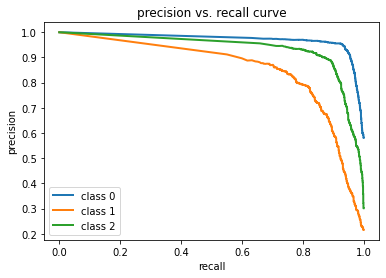

In [27]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision = dict()
recall = dict()
_probs = model.predict_proba(x_test)
for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        _probs[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

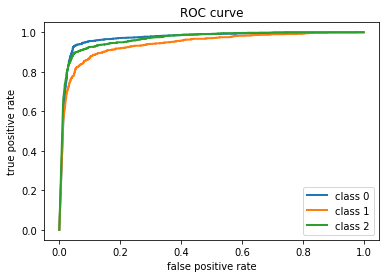

In [28]:
fpr = dict()
tpr = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                  _probs[:, i])
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

In [29]:
from sklearn.ensemble import RandomForestClassifier
#cv = CountVectorizer(max_features = 150)
classifier = RandomForestClassifier(n_estimators = 25, criterion = 'entropy',min_samples_split=2,random_state = 0,bootstrap=True)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [30]:
y_pred = classifier.predict(x_test)
#print(y_pred)
def decoder(predictions):
    return (predictions == predictions.max(axis=1, keepdims=True)).astype(float)
prediction_y = decoder(y_pred)
#prediction_y
acutal_y = uniques[y_test.argmax(1)]
predict_y = uniques[prediction_y.argmax(1)]
print(acutal_y)
print(predict_y)

[0 2 0 ... 2 0 0]
[0 0 0 ... 2 0 0]


In [32]:
import sklearn.metrics  as skmet
cm = skmet.confusion_matrix(acutal_y, predict_y)
print("Confusion Mat: \n", cm)
print("Recall: ", skmet.recall_score(acutal_y, predict_y, average = "weighted"))
print("Precision: ", skmet.precision_score(acutal_y, predict_y, average = "weighted"))
print("F1 Score: ", skmet.f1_score(acutal_y, predict_y, average = "weighted"))
print("Accuracy: ", skmet.accuracy_score(acutal_y, predict_y))

Confusion Mat: 
 [[2547    2   55]
 [ 459  488   50]
 [ 748    9  756]]
Recall:  0.741298396558467
Precision:  0.7959057710632949
F1 Score:  0.7235806007842807
Accuracy:  0.741298396558467


In [33]:
#appllying decision tree
from sklearn.tree import DecisionTreeClassifier
classifier1 = DecisionTreeClassifier(min_samples_split=7,criterion = 'entropy', random_state = 0,max_depth=None)
classifier1.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [34]:
y_pred = classifier1.predict(x_test)
print(y_pred)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [35]:
def decoder(predictions):
    return (predictions == predictions.max(axis=1, keepdims=True)).astype(float)
prediction_y = decoder(y_pred)
acutal_y = uniques[y_test.argmax(1)]
predict_y = uniques[prediction_y.argmax(1)]
print(acutal_y)
print(predict_y)

[0 2 0 ... 2 0 0]
[0 2 2 ... 2 2 0]


In [37]:
import sklearn.metrics  as skmet
cm = skmet.confusion_matrix(acutal_y, predict_y)
print("Confusion Mat: \n", cm)
print("Recall: ", skmet.recall_score(acutal_y, predict_y, average = "weighted"))
print("Precision: ", skmet.precision_score(acutal_y, predict_y, average = "weighted"))
print("F1 Score: ", skmet.f1_score(acutal_y, predict_y, average = "weighted"))
print("Accuracy: ", skmet.accuracy_score(acutal_y, predict_y))

Confusion Mat: 
 [[2013  244  347]
 [ 259  556  182]
 [ 441  177  895]]
Recall:  0.677356276886977
Precision:  0.6747053439774581
F1 Score:  0.6756917043883444
Accuracy:  0.677356276886977


In [33]:
!pip install matplotlib